# Change point based Clustering

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [6]:
from eval.tsdr import load_tsdr_by_chaos

tt_dataset_by_chaos = load_tsdr_by_chaos(
    TRAINTICKET_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [107]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "orders-db")][1]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

orders-db/pod-cpu-hog/9n6mf-1


((180, 183),
 '2023-02-17-argowf-chaos-9n6mf-orders-db_pod-cpu-hog_1.json of orders-db/pod-cpu-hog')

In [108]:
from tsdr.outlierdetection.spot import detect_anomalies_with_spot
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma

sli_data: pd.DataFrame = dataset.loc[
    :, [col for col in record.pk.get_root_metrics() if col in dataset.columns]
]  # retrieve only existing slis
most_anomalous_sli_name = sli_data.apply(lambda x: detect_anomalies_with_spot(x.to_numpy(), 4*30)[1]).idxmax()
most_anomalous_sli_data = sli_data[most_anomalous_sli_name].to_numpy()
most_anomalous_sli_name 

's-front-end_latency'

In [109]:
cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cols]

In [110]:
from tsdr.multireducer import change_point_clustering, change_point_clustering_with_kde
from tsdr.smooth import moving_average

In [111]:
# from tsdr import tsdr

# tsdr.Tsdr(enable_unireducer=False, enable_multireducer=True, univariate_series_func_or_name="residual_integral",
#     step2_clustering_method_name="changepoint",
#     step2_changepoint_n_bkps=1,
#     step2_changepoint_proba_threshold=0.5,
#     step2_clustering_choice_method="max_members_changepoint",
#     step2_changepoint_cluster_selection_method="leaf",
#     step2_changepoint_cluster_selection_epsilon=3.0,
#     step2_changepoint_allow_single_cluster=True,
#     step2_clustering_n_workers=1,
# ).reduce_multivariate_series(
#     dataset,
#     record.pk,
#     n_workers=1,
# )

In [112]:
# cinfo, remove_metrics = change_point_clustering(
#     cause_dataset,
#     n_bkps=1,
#     proba_threshold=0.5,
#     choice_method="max_members_changepoint",
#     cluster_selection_epsilon=3.0,
#     cluster_selection_method="leaf",
#     cluster_allow_single_cluster=True,
#     sli_data=sli_data,
#     n_jobs=-1,
# )
cinfo, remove_metrics = change_point_clustering_with_kde(
    cause_dataset,
    n_bkps=1,
    kde_bandwidth=0.1,
    n_jobs=-1,
)
cinfo, remove_metrics

({'c-orders-db_cpu_cfs_throttled_seconds_total': [],
  'c-orders-db_network_transmit_packets_total': [],
  'c-orders-db_cpu_usage_seconds_total': [],
  'c-orders-db_cpu_system_seconds_total': [],
  'c-orders-db_cpu_cfs_periods_total': [],
  'c-orders-db_cpu_cfs_throttled_periods_total': [],
  'c-orders-db_cpu_user_seconds_total': [],
  'c-orders-db_memory_mapped_file': []},
 ['c-orders-db_memory_rss',
  'c-orders-db_last_seen',
  'c-orders-db_threads',
  'c-orders-db_fs_writes_bytes_total',
  'c-orders-db_network_receive_packets_total',
  'c-orders-db_memory_max_usage_bytes',
  'c-orders-db_fs_writes_total',
  'c-orders-db_fs_reads_bytes_total',
  'c-orders-db_memory_usage_bytes',
  'c-orders-db_fs_reads_total',
  'c-orders-db_memory_cache',
  'c-orders-db_memory_working_set_bytes',
  'c-orders-db_network_receive_bytes_total',
  'c-orders-db_network_transmit_bytes_total',
  'c-orders-db_blkio_device_usage_total'])

In [113]:
import ruptures as rpt
import hdbscan 
from hdbscan.prediction import all_points_membership_vectors, all_points_outlier_membership_vector

from collections import defaultdict
import itertools

In [114]:
# cause_dataset = cause_dataset.apply(lambda x: moving_average(x, window_size=5))
# sli_data = sli_data.apply(lambda x: moving_average(x, window_size=5))

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


163

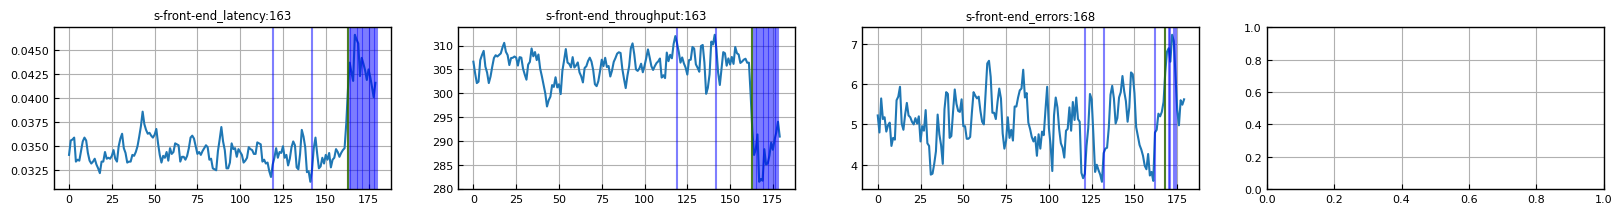

In [115]:
import math

binseg = rpt.Binseg(model="normal", jump=1)
fig, axs = plt.subplots(math.ceil(sli_data.shape[1]/4), ncols=4)
fig.set_size_inches(20, 0.7*sli_data.shape[1])
bkps = []
for ax, sli in zip(axs.flatten(), sli_data.columns):
    sli_y = sli_data[sli].values
    bkp = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[0]
    bkps.append(bkp)
    ax.plot(sli_y)
    ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(f"{sli}:{bkp}")

    backward_idx = 4*20
    alarms, scores = detect_anomalies_with_spot(sli_y, anomalous_start_idx=backward_idx, return_score=True, proba=1e-4)
    # alarms, scores = detect_anomalies_with_zscore_nsigma(sli_y, anomalous_start_idx=backward_idx, return_score=True, n_sigmas=3.0, robust=True)
    for alarm in alarms:
        a = (sli_y.size - backward_idx) + alarm
        ax.axvline(a, color='blue', alpha=0.5)

    _bkps = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[:-1]
    for bkp in _bkps:
        ax.axvline(bkp, color='green', alpha=0.7)
    
slis_bkp: int = binseg.fit(sli_data.apply(scipy.stats.zscore).values).predict(n_bkps=1)[0]
slis_bkp

## Change points detection

In [123]:
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma_cause_rank

data = cause_dataset
n_bkps = 1

metrics = data.columns.tolist()
binseg = rpt.Binseg(model="normal", jump=1)
change_points: list[int] = []
data_size = data.shape[0]
for metric in metrics:
    x = data[metric].to_numpy()
    anomaly, scores = detect_anomalies_with_zscore_nsigma_cause_rank(x, anomalous_start_idx=4*25, n_sigmas=2.0)
    data_size = len(scores)
    # change_point = binseg.fit(scipy.stats.zscore(x)).predict(n_bkps=n_bkps)[0]
    change_point = binseg.fit(scores).predict(n_bkps=n_bkps)[0]
    change_points.append(change_point)
metric_to_bkp = {metric: bkp for metric, bkp in zip(metrics, change_points)}

# print(
#     "multivariate bkp",
#     binseg.fit(data.apply(scipy.stats.zscore)).predict(n_bkps=n_bkps)[0],
# )

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


## KDE 1d clustering

[array([19, 21]), array([8]), array([ 2, 12]), array([16]), array([ 4, 13]), array([ 0,  1,  3,  6,  7,  9, 10, 11, 14, 15, 17, 18, 22]), array([ 5, 20])]


,metric,cluster_id,change_point
19,c-orders-db_fs_writes_bytes_total,0,7
21,c-orders-db_blkio_device_usage_total,0,7
8,c-orders-db_cpu_cfs_throttled_periods_total,1,27
12,c-orders-db_memory_max_usage_bytes,2,35
2,c-orders-db_network_receive_bytes_total,2,39
16,c-orders-db_last_seen,3,50
13,c-orders-db_network_receive_packets_total,4,77
4,c-orders-db_network_transmit_bytes_total,4,78
9,c-orders-db_cpu_cfs_throttled_seconds_total,5,82
0,c-orders-db_memory_cache,5,83


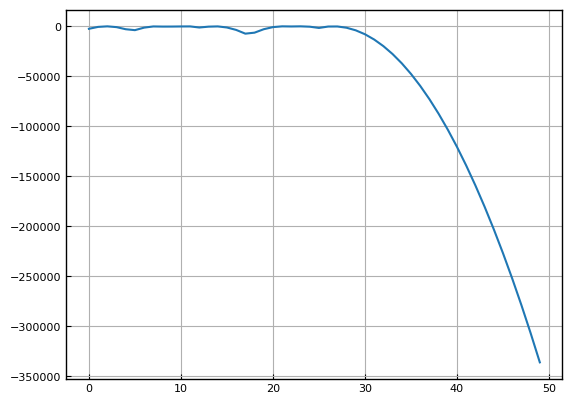

In [124]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

# x = np.diff(a)
x = np.array(change_points, dtype=int)
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x.reshape(-1, 1))
minval, maxval = 0, data_size - 1
s = np.linspace(minval, maxval)
e = kde.score_samples(s.reshape(-1, 1))
# display(list(zip(b, e)))
plt.plot(e)

mi = argrelextrema(e, np.less)[0]

clusters = []
if len(mi) <= 0:
    print("1 cluster")
    clusters.append(np.arange(len(x)))
else:
    clusters.append(np.where(x < s[mi][0])[0])  # most left cluster
    # all middle cluster
    for i_cluster in range(len(mi)-1):
        clusters.append(np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster+1]))[0])
    clusters.append(np.where(x >= s[mi][-1])[0])  # most right cluster

print(clusters) 
x_indice_to_cluster_id = {x_indice: cluster_id for cluster_id, x_indices in enumerate(clusters) for x_indice in x_indices}
cluster_labels = np.array([x_indice_to_cluster_id[x_indice] for x_indice in range(len(x))])
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, x), columns=["metric", "cluster_id", "change_point"]).sort_values("change_point"))
cluster_id_to_metrics = {cluster_id: [metrics[x_indice] for x_indice in x_indices] for cluster_id, x_indices in enumerate(clusters)}

In [125]:
cluster_selection_epsilon = 3.0
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric=lambda x, y: np.abs(x - y),
    allow_single_cluster=True,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=cluster_selection_epsilon,
).fit(np.array([change_points]).T)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, clusterer.labels_, change_points, clusterer.outlier_scores_, clusterer.probabilities_), columns=["metric", "cluster_id", "change_point", "outlier_score", "probability"]))
print("persistence", clusterer.cluster_persistence_)


from dataclasses import dataclass
from collections import UserList


@dataclass
class ClusterMember:
    metric_name: str
    change_point: int
    proba: float

@dataclass
class Cluster:
    cluster_id: int  # -1 means a noise cluster
    centroid: int  # -1 means a noise cluster
    members: list[ClusterMember]

    @classmethod
    def from_raw_members(cls, cluster_id: int, centroid: int, members: list[tuple[str, int, float]]):
        return cls(cluster_id, centroid, [ClusterMember(*member) for member in members])

    def _has_near_members(self, target: ClusterMember, eps: int) -> bool:
        _members = sorted(self.members, key=lambda m: m.change_point)
        for _member in _members:
            if _member.change_point == target.change_point:
                continue
            if abs(_member.change_point - target.change_point) < eps:
                return True
        return False

    def _inliers(self, threshold: float = 0.0, eps: int = 1) -> list[ClusterMember]:
        assert 0 <= threshold <= 1
        return [m for m in self.members if m.proba >= threshold or self._has_near_members(m, eps)]
    
    def keep_only_inliers(self, threshold: float, eps: int) -> None:
        self.members = self._inliers(threshold, eps)
    
    def size(self) -> int:
        return len(self.members)


class Clusters(UserList[Cluster]):
    def __init__(self, clusters: list[Cluster]):
        super().__init__(UserList(clusters))

    @classmethod
    def from_raw_values(cls, clusterer: hdbscan.HDBSCAN, metrics: list[str], change_points: list[int]):
        _cluster_id_to_centroid = {
            cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
            for cluster_id in np.unique(clusterer.labels_)
            if cluster_id != -1  # skip noise cluster
        }
        _cluster_id_to_members = defaultdict(list)
        for label, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
            centroid: int = _cluster_id_to_centroid.get(label, -1)  # -1 means a noise cluster
            _cluster_id_to_members[(label, centroid)].append((metric, change_point, proba))

        clusters: list[Cluster] = []
        for (cluster_id, centroid), members in sorted(_cluster_id_to_members.items(), key=lambda x: x[0][1]):
            clusters.append(Cluster.from_raw_members(cluster_id, centroid, members))
        return Clusters(clusters)
    
    def inliner(self, threshold: float = 1.0, eps: int = 1, copy: bool = True):
        if copy:
            _orig_clusters = self.data
            return Clusters([Cluster(c.cluster_id, c.centroid, c._inliers(threshold=threshold, eps=eps)) for c in _orig_clusters if c.cluster_id != -1])
        else:
            for c in self:
                if c.cluster_id == -1:
                    self.data.remove(c)
                    continue
                c.keep_only_inliers(threshold=threshold, eps=eps)
            return self
    
    def cluster_of_max_size(self) -> Cluster:
        return max(self, key=lambda c: c.size())
    
    def noise(self) -> Cluster:
        return next(c for c in self.data if c.cluster_id == -1)
    

# cluster_id_to_centroid = {
#     cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
#     for cluster_id in np.unique(clusterer.labels_)
#     if cluster_id != -1  # skip noise cluster
# }
# cluster_id_to_change_points: dict[int, list[int]] = defaultdict(list)
# clusters_with_centroid: dict[tuple[int, int], list[str]] = defaultdict(list)
# # print(list(zip(clusterer.labels_, metrics, change_points)))
# for cluster_id, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
#     if cluster_id == -1:  # skip noise features
#         continue
#     centroid = cluster_id_to_centroid[cluster_id]
#     clusters_with_centroid[(cluster_id, centroid)].append(metric)
#     cluster_id_to_change_points[cluster_id].append(change_point)

# remove outliers
# for (cluster_id, centroid), members in clusters_with_centroid.items():
#     if proba <= 0.5 and :
#         continue
# # choose a cluster having max metrics and the adjacent clusters
# import pprint
# for x in clusters_with_centroid.items():
#     print(agglomerative_coefficient(np.array(cluster_id_to_change_points[x[0][0]], dtype=int), x[0][1]), x)

clusters = Clusters.from_raw_values(clusterer, metrics, change_points)
inliners = clusters.inliner(threshold=0.5, eps=int(cluster_selection_epsilon), copy=True)
# keep_clusters = [inliners.cluster_of_max_size()]
# print("keep_clusters", keep_clusters)

# keep_metrics: list[str] = [m.metric_name for m in keep_clusters[0].members]
# remove_metrics: list[str] = list(set(metrics) - set(keep_metrics))
# clustering_info: dict[str, list[str]] = {metric: [] for metric in keep_metrics}
# clustering_info, remove_metrics

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1379: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


,metric,cluster_id,change_point,outlier_score,probability
0,c-orders-db_memory_cache,3,83,0.000000,1.000000
1,c-orders-db_memory_rss,3,83,0.000000,1.000000
2,c-orders-db_network_receive_bytes_total,1,39,0.000000,1.000000
3,c-orders-db_memory_usage_bytes,3,83,0.000000,1.000000
4,c-orders-db_network_transmit_bytes_total,4,78,0.000000,1.000000
5,c-orders-db_fs_reads_total,0,97,0.000000,1.000000
6,c-orders-db_memory_working_set_bytes,3,83,0.000000,1.000000
7,c-orders-db_cpu_cfs_periods_total,3,84,0.000000,1.000000
8,c-orders-db_cpu_cfs_throttled_periods_total,1,27,0.500000,0.500000
9,c-orders-db_cpu_cfs_throttled_seconds_total,3,82,NaN,1.000000


persistence [1. 1. 1. 1. 1.]


In [126]:
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

eps = 2/dataset.shape[0]
a = np.sort(change_points)
vfunc = np.vectorize(lambda x: 0 if x/dataset.shape[0] <= eps else x)
diff = vfunc(np.diff(a))
print("diff", diff)
# rel_diff = [diff[i]/a[i] for i in range(len(diff))]
# smoothed_a = interp1d(x=np.arange(0, len(diff)), y=diff, kind="cubic")(np.arange(0, len(diff)))
# plt.plot(smoothed_a)
seg_indices = argrelextrema(diff, np.greater)[0] + 2
if abs(diff[0] - diff[1])/dataset.shape[0] > eps:
    seg_indices = np.append(seg_indices, 1)
if abs(diff[-1] - diff[-2])/dataset.shape[0] > eps:
    seg_indices = np.append(seg_indices, len(diff))
seg_indices = np.sort(seg_indices)
print("segment", seg_indices)

cluster_labels = []
for label, clusters in enumerate(np.split(a, seg_indices)):
    for _ in clusters:
        cluster_labels.append(label)
print(cluster_labels)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, a), columns=["metric", "cluster_id", "change_point"]))

diff [ 0 20  8  4 11 27  0  4  0  0  0  0  0  0  0  0  0  0  0  0 12  0]
segment [ 1  3  7  9 22 22]
[0, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6]


,metric,cluster_id,change_point
0,c-orders-db_memory_cache,0,7
1,c-orders-db_memory_rss,1,7
2,c-orders-db_network_receive_bytes_total,1,27
3,c-orders-db_memory_usage_bytes,2,35
4,c-orders-db_network_transmit_bytes_total,2,39
5,c-orders-db_fs_reads_total,2,50
6,c-orders-db_memory_working_set_bytes,2,77
7,c-orders-db_cpu_cfs_periods_total,3,78
8,c-orders-db_cpu_cfs_throttled_periods_total,3,82
9,c-orders-db_cpu_cfs_throttled_seconds_total,4,83


0 (0, 8)
1 (8, 28)
2 (28, 36)
3 (36, 40)
4 (40, 51)
5 (51, 84)
6 (84, 98)
[0, 0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6]


,metric,cluster_id,change_point
0,c-orders-db_memory_cache,0,7
1,c-orders-db_memory_rss,0,7
2,c-orders-db_network_receive_bytes_total,1,27
3,c-orders-db_memory_usage_bytes,2,35
4,c-orders-db_network_transmit_bytes_total,3,39
5,c-orders-db_fs_reads_total,4,50
6,c-orders-db_memory_working_set_bytes,5,77
7,c-orders-db_cpu_cfs_periods_total,5,78
8,c-orders-db_cpu_cfs_throttled_periods_total,5,82
9,c-orders-db_cpu_cfs_throttled_seconds_total,5,83


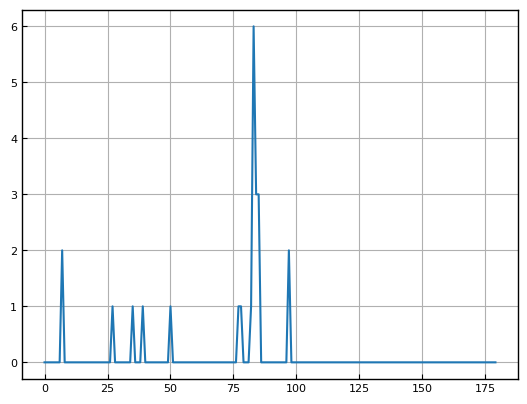

In [127]:
a = np.sort(np.array(change_points, dtype=int))

b = np.zeros(dataset.shape[0], dtype=int)
for i in range(b.size):
    indices = [_ for _ in a if _ == i]
    b[i] = len(indices)

plt.plot(b)
seg_indices = argrelextrema(b, np.greater)[0] + 1

cluster_labels = []
for label, indice in enumerate(seg_indices):
    if label == 0:
        left = 0
    else:
        left = seg_indices[label - 1]
    right = seg_indices[label]
    print(label, (left, right))
    clusters = np.where((a >= left) & (a < right))[0]
    for _ in clusters:
        cluster_labels.append(label)
print(cluster_labels)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, a), columns=["metric", "cluster_id", "change_point"]))

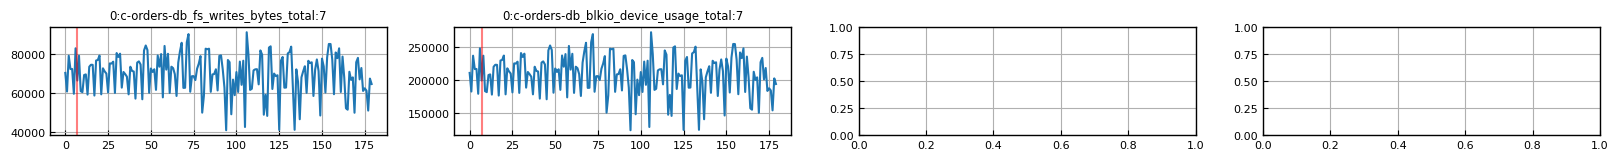

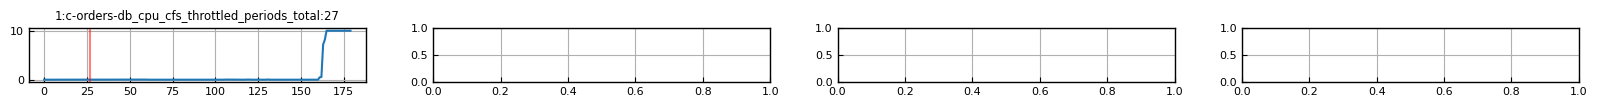

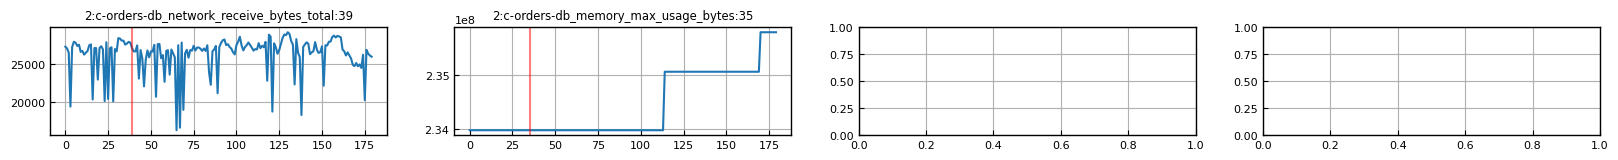

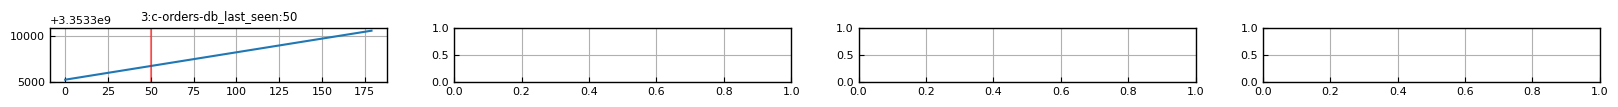

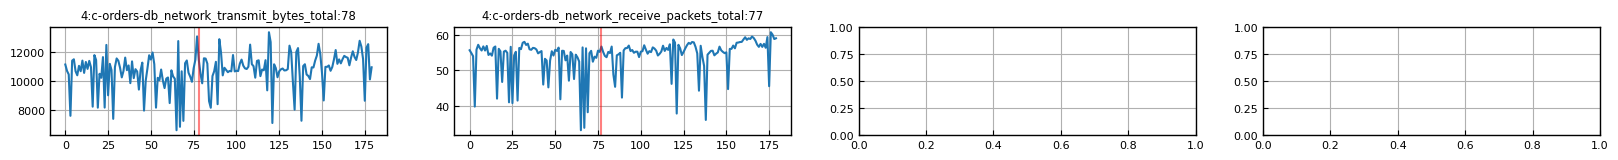

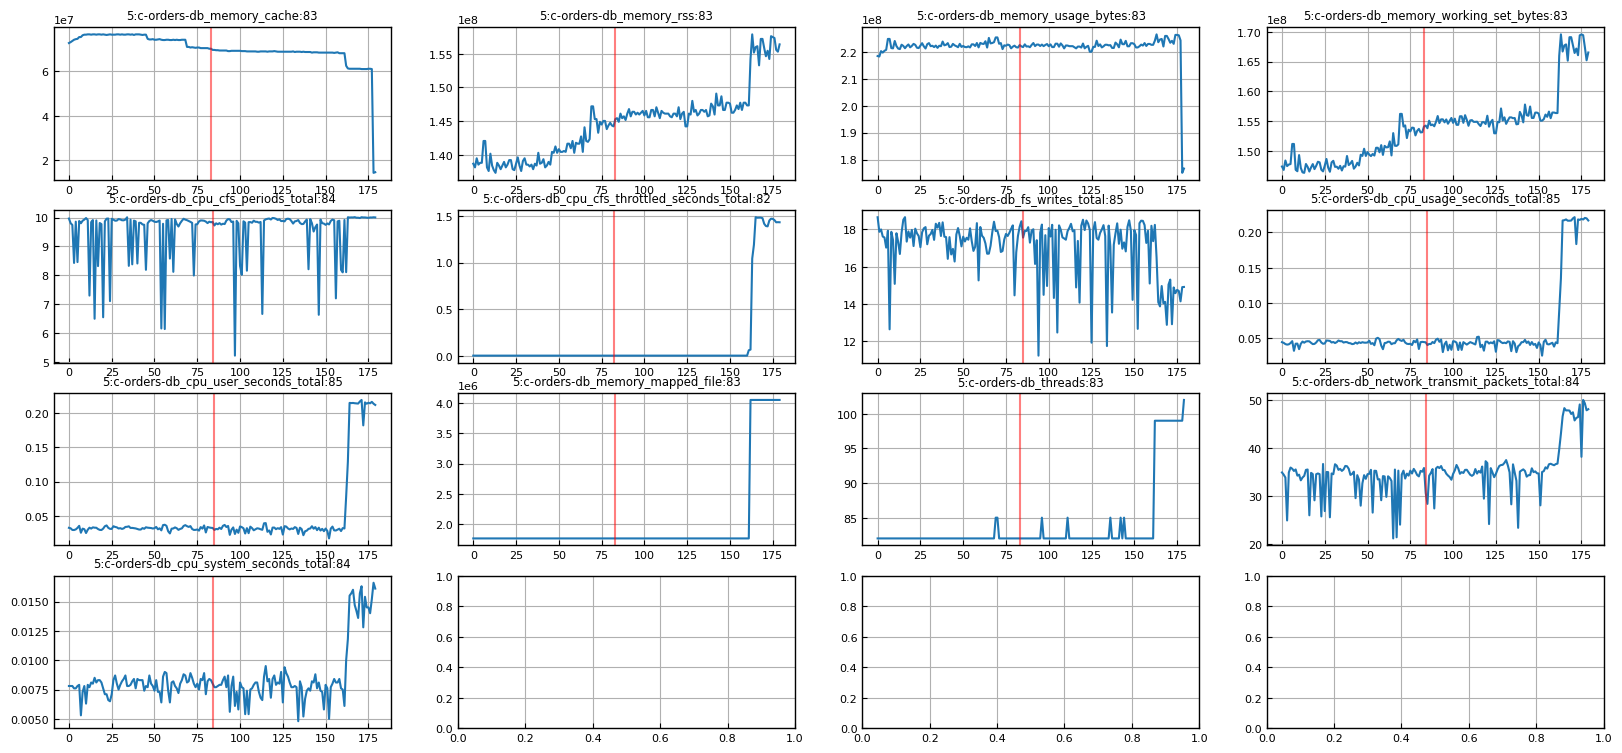

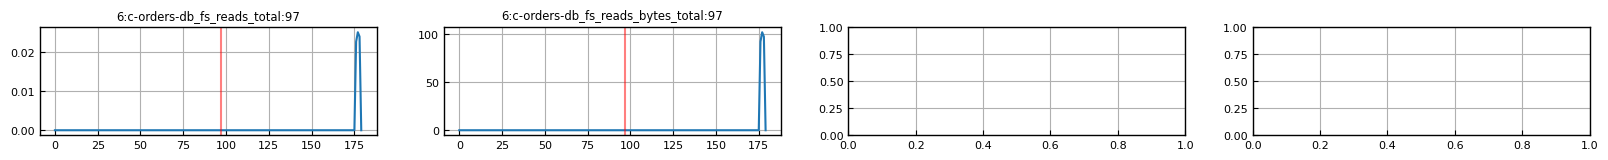

In [128]:
import math
from notebooklib import plot

plt.close()

for cluster_id, metrics in cluster_id_to_metrics.items():
    fig, axs = plt.subplots(math.ceil(len(metrics)/4), ncols=4)
    fig.set_size_inches(20, 0.7*len(metrics))
    for ax, member in zip(axs.flatten(), metrics):
        metric = member
        x = cause_dataset[metric].to_numpy()
        ax.plot(x)
        bkp = metric_to_bkp[metric]
        ax.axvline(bkp, color='red', alpha=0.5)
        ax.set_title(f"{cluster_id}:{metric}:{bkp}")